# PlaNet-inspired geolocation classification CNN

Source: https://github.com/multimedia-berkeley/tutorials (Slightly altered)

PlaNet: Weyand, Tobias, Ilya Kostrikov, and James Philbin. "Planet-photo geolocation with convolutional neural networks." European Conference on Computer Vision. Springer, Cham, 2016. (https://arxiv.org/pdf/1602.05314.pdf)

This notebook is designed to be run in [Google Colab](https://colab.research.google.com). 


## Download model

Downloading pre-trained ResNet101 model. The model is trained on the [YFCC100M dataset](http://projects.dfki.uni-kl.de/yfcc100m/). We also download the dataset used for testing. By running this you download the model and dataset into the temporary memory, so it gets deleted once you interrupt or restart the runtime. You can find the model files under 'content/models/'.

In [ ]:
import os
import urllib

path = 'https://s3.amazonaws.com/mmcommons-tutorial/models/'
model_path = 'models/'
if not os.path.exists(model_path):
    os.mkdir(model_path)
urllib.request.urlretrieve(path+'RN101-5k500-symbol.json', model_path+'RN101-5k500-symbol.json')
urllib.request.urlretrieve(path+'RN101-5k500-0012.params', model_path+'RN101-5k500-0012.params')

#download test set used for evaluation
urllib.request.urlretrieve('https://s3.amazonaws.com/mmcommons-tutorial/datasets/location-estimation/mediaeval2016_test', 'mediaeval2016_test')

('mediaeval2016_test', <http.client.HTTPMessage at 0x7f9fa9d750b8>)

## Installing MXNet 
[MXNet](https://mxnet.apache.org/) is an open sourced deep learning framework by Apache. The installation can take a moment, because some files need to be downloaded for this.

In [ ]:
!pip install mxnet

     |████████████████████████████████| 68.7MB 79kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
%matplotlib inline
import mxnet as mx
import logging
import numpy as np
from skimage import io, transform
from collections import namedtuple
from math import radians, sin, cos, sqrt, asin
from google.colab import drive


## Load model and labels
Loading the model and setting information like size of input and working device (CPU or GPU). This might throw a UserWarning, but it does not affect the performance of the network.
If you want to run this on your own machine and GPU set the context to GPU. In Google Colab this for me unfortunately lead to crashing, so we have to use the CPU-version here.

In [ ]:
# Load the pre-trained model
prefix = "/content/models/RN101-5k500"
load_epoch = 12
sym, arg_params, aux_params = mx.model.load_checkpoint(prefix, 12)
# if you use this on your own machine and want to work with your GPU, change the context to mx.gpu()
mod = mx.mod.Module(symbol=sym, context=mx.cpu())
mod.bind([('data', (1,3,224,224))], for_training=False)
mod.set_params(arg_params, aux_params, allow_missing=True)


/usr/local/lib/python3.6/dist-packages/mxnet/module/base_module.py:67: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


Before we can load the labels you need to download the 'grids.txt' file from our repository. In this file the geographical cells are described by the longitude and latitude in their center. After downloading the file you need to upload it to colab, to the folder '/content/'. For this simply click on the folder symbol on the left and then on the upload button on the top left.

In [ ]:
# Load labels.
grids, ground_truth = [], {}
with open('grids.txt', 'r') as f:
    for line in f:
        line = line.strip().split('\t')
        lat = float(line[1])
        lng = float(line[2])
        grids.append((lat, lng))
with open('mediaeval2016_test', 'r') as f:
    for line in f:
        line = line.strip().split('\t')
        imghash = line[-1]
        lng = float(line[2])
        lat = float(line[3])
        ground_truth[imghash] = (lat, lng)

In [ ]:
def distance(p1, p2):
        R = 6371 # Earth radius in km
        lat1, lng1, lat2, lng2 = map(radians, (p1[0], p1[1], p2[0], p2[1]))
        dlat = lat2 - lat1
        dlng = lng2 - lng1
        a = sin(dlat * 0.5) ** 2 + cos(lat1) * cos(lat2) * (sin(dlng * 0.5) ** 2)
        return 2 * R * asin(sqrt(a))


## Preprocess the images

In [ ]:
# mean image for preprocessing
mean_rgb = np.array([123.68, 116.779, 103.939])
mean_rgb = mean_rgb.reshape((3, 1, 1))

def PreprocessImage(path, show_img=False):
    # load image.
    img = io.imread(path)
    # We crop image from center to get size 224x224.
    short_side = min(img.shape[:2])
    yy = int((img.shape[0] - short_side) / 2)
    xx = int((img.shape[1] - short_side) / 2)
    crop_img = img[yy : yy + short_side, xx : xx + short_side]
    resized_img = transform.resize(crop_img, (224,224))
    if show_img:
        io.imshow(resized_img)
    # convert to numpy.ndarray
    sample = np.asarray(resized_img) * 256
    # swap axes to make image from (224, 224, 3) to (3, 224, 224)
    sample = np.swapaxes(sample, 0, 2)
    sample = np.swapaxes(sample, 1, 2)
    # sub mean 
    normed_img = sample - mean_rgb
    normed_img = normed_img.reshape((1, 3, 224, 224))
    return [mx.nd.array(normed_img)]

## Predict images from the data set

These functions can be used to make predictions about images that already are in the dataset. The images can be found [here](http://multimedia-commons.s3-website-us-west-2.amazonaws.com/?prefix=data/images/), however it seems that not all images are part of the data set, so it can happen that an image is not found, if you change the predefined link.



In [ ]:
# defining functions to make a forward move through the network to predict locations
# these functions can only be used for the MultimediaCommons images

Batch = namedtuple('Batch', ['data'])
def predict_and_evaluate(imgname, prefix='images/'):
    result = list()
    imghash = imgname[:-4]
    gt_location = ground_truth[imghash]
    # Get preprocessed batch (single image batch)
    download_yfcc(imgname, prefix)
    batch = PreprocessImage(prefix + imgname, True)
    # Predict and show top 5 results!
    mod.forward(Batch(batch), is_train=False)
    prob = mod.get_outputs()[0].asnumpy()[0]
    pred = np.argsort(prob)[::-1]
    print("Ground truth: ", gt_location)
    result.append(gt_location)
    for i in range(5):
        pred_loc = grids[int(pred[i])]
        dist = distance(gt_location, pred_loc)
        res = (i+1, prob[pred[i]], pred_loc, "distance: ", dist)
        print('rank=%d, prob=%f, lat=%s, lng=%s, dist from groundtruth=%f km' \
              % (i+1, prob[pred[i]], pred_loc[0], pred_loc[1], dist))
        result.append(res[2])
    return result

def download_yfcc(imgname, img_directory):
    #download the image if not downloaded
    if not os.path.exists(img_directory):
        os.mkdir(img_directory)
    url_prefix = 'https://multimedia-commons.s3-us-west-2.amazonaws.com/data/images/'
    filepath = os.path.join(img_directory, imgname)
    if not os.path.exists(filepath):
        url = url_prefix + imgname[0:3] + '/' + imgname[3:6] + '/' +imgname
        filepath, _ = urllib.request.urlretrieve(url, filepath)
        statinfo = os.stat(filepath)
        print('Succesfully downloaded', imgname, statinfo.st_size, 'bytes.')
    return filepath

Succesfully downloaded d661b83d659af4d818ddd6edf54096.jpg 173087 bytes.
Ground truth:  (36.016233, -114.737316)
rank=1, prob=0.742574, lat=36.0164119656, lng=-114.737289028, dist from groundtruth=0.020047 km
rank=2, prob=0.161115, lat=36.0164436503, lng=-114.740746605, dist from groundtruth=0.309436 km
rank=3, prob=0.084363, lat=36.0141364684, lng=-114.733238705, dist from groundtruth=0.434543 km
rank=4, prob=0.001835, lat=35.3251732371, lng=-114.922660411, dist from groundtruth=78.645110 km
rank=5, prob=0.001427, lat=36.8630814967, lng=-111.561140839, dist from groundtruth=299.302093 km


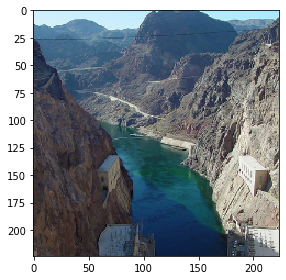

In [ ]:
imgname = 'd661b83d659af4d818ddd6edf54096.jpg'
result = predict_and_evaluate(imgname)

## Predict the location of your own images
If you want to test the network with your own images, upload the picture into the '/content/images/' folder on colab. You can also find it on the left, where you uploaded the 'grids.txt' file. Then simple replace the url with the name of your image. Then use predict to let the network predict the location. If you want to test photos from the web, simply copy-paste the link to the photo, set it as the url and let the network predict its' location.

In [ ]:
def predict(imgurl, prefix='images/'):
    download_url(imgurl, prefix)
    imgname = imgurl.split('/')[-1]
    batch = PreprocessImage(prefix + imgname, True)
    #predict and show top 5 results
    mod.forward(Batch(batch), is_train=False)
    prob = mod.get_outputs()[0].asnumpy()[0]
    pred = np.argsort(prob)[::-1]
    result = list()
    for i in range(5):
        pred_loc = grids[int(pred[i])]
        res = (i+1, prob[pred[i]], pred_loc)
        print('rank=%d, prob=%f, lat=%s, lng=%s' \
              % (i+1, prob[pred[i]], pred_loc[0], pred_loc[1]))
        result.append(res[2])
    return result    

def download_url(imgurl, img_directory):
    if not os.path.exists(img_directory):
        os.mkdir(img_directory)
    imgname = imgurl.split('/')[-1]
    filepath = os.path.join(img_directory, imgname)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(imgurl, filepath)
        statinfo = os.stat(filepath)
        print('Succesfully downloaded', imgname, statinfo.st_size, 'bytes.')
    return filepath

Succesfully downloaded n-tower-e-20160302.jpg 7845956 bytes.
rank=1, prob=0.610419, lat=35.6599344486, lng=139.728919109
rank=2, prob=0.091065, lat=35.6546613641, lng=139.745685815
rank=3, prob=0.047789, lat=35.661420407, lng=139.734938934
rank=4, prob=0.029891, lat=35.6650066761, lng=139.728878859
rank=5, prob=0.027305, lat=35.6611012521, lng=139.758684384


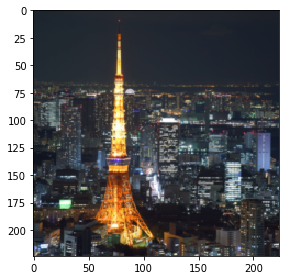

In [ ]:
#tokyo tower
url = 'http://www.japantimes.co.jp/wp-content/uploads/2016/03/n-tower-e-20160302.jpg' 
result = predict(url)